In [183]:
!pip install textblob


# Import Libraries

In [184]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Data Loading

In [185]:
# Load dataset
file_path = 'IMDB_dataset_01.csv'  
dataset = pd.read_csv(file_path)


# Exploratory Data Analysis

In [186]:
# Data overview
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1600 non-null   object
 1   sentiment  1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB


In [187]:
# Display dataset summary
dataset.head()

,review,sentiment
0,I really liked this Summerslam due to the look...,positive
1,Not many television shows appeal to quite as m...,positive
2,The film quickly gets to a major chase scene w...,negative
3,Jane Austen would definitely approve of this o...,positive
4,Expectations were somewhat high for me when I ...,negative


In [188]:
print(f"Total Rows: {dataset.shape[0]}")
print(f"Total Columns: {dataset.shape[1]}")

Total Rows: 1600
Total Columns: 2


In [189]:
# Check for missing values
missing_values = dataset.isnull().sum()
print("\nMissing Values Summary:")
print(missing_values)


Missing Values Summary:
review       0
sentiment    0
dtype: int64


In [190]:
dataset.describe()

,review,sentiment
count,1600,1600
unique,1600,2
top,I really liked this Summerslam due to the look...,negative
freq,1,822


In [191]:
print("\nClass Distribution:")
print(dataset['sentiment'].value_counts())


Class Distribution:
sentiment
negative    822
positive    778
Name: count, dtype: int64


C:\Users\kuwar\AppData\Local\Temp\ipykernel_27184\4154170641.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dataset['sentiment'].value_counts().index,


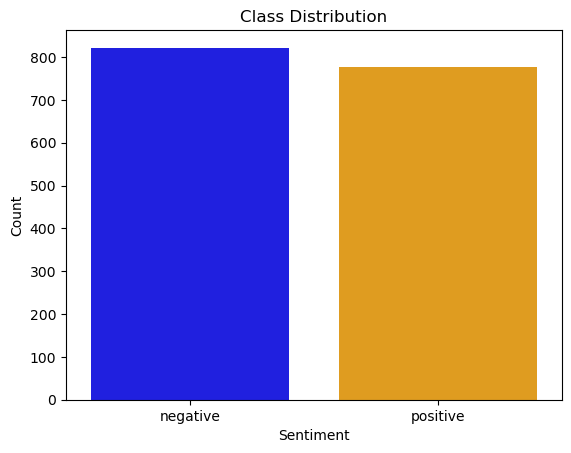

In [192]:
# Plot class distribution
sns.barplot(x=dataset['sentiment'].value_counts().index,
            y=dataset['sentiment'].value_counts().values,
           palette=["blue", "orange"])
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


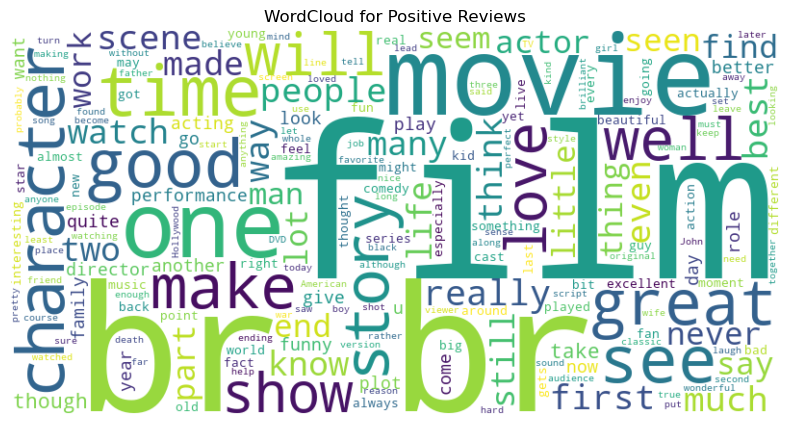

In [194]:
# Word Clouds for positive review
# Filter positive reviews
positive_reviews = " ".join(dataset[dataset['sentiment'] == 'positive']['review'])
# Generate WordCloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
# Plot WordCloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Positive Reviews")
plt.show()



Top Words in Positive Reviews:
[('the', 9022), ('and', 5172), ('a', 4898), ('of', 4606), ('to', 3963), ('is', 3454), ('in', 2741), ('I', 1920), ('that', 1836), ('it', 1752)]


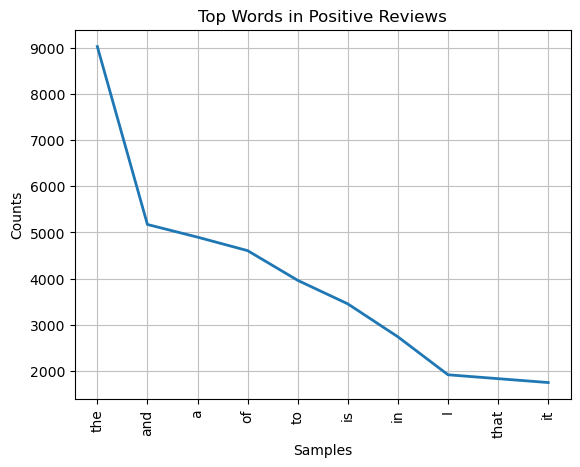

<Axes: title={'center': 'Top Words in Positive Reviews'}, xlabel='Samples', ylabel='Counts'>

In [195]:
# Top Word Frequency Distribution in positive reviews
# Filter positive reviews and combine text
positive_text = " ".join(dataset[dataset['sentiment'] == 'positive']['review'])
positive_tokens = positive_text.split()
positive_freq_dist = FreqDist(positive_tokens)
print("\nTop Words in Positive Reviews:")
print(positive_freq_dist.most_common(10))
positive_freq_dist.plot(10, title="Top Words in Positive Reviews")

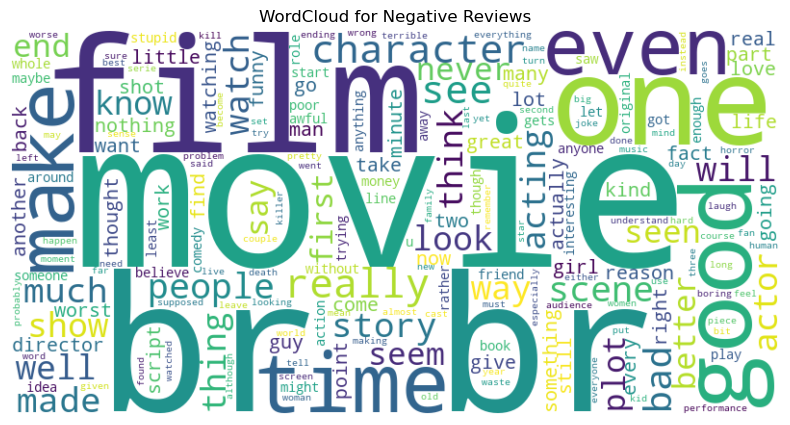

In [197]:
# Filter negative reviews
negative_reviews = " ".join(dataset[dataset['sentiment'] == 'negative']['review'])

# Generate WordCloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
# Plot WordCloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Negative Reviews")
plt.show()


Top Words in Negative Reviews:
[('the', 9139), ('a', 5043), ('of', 4472), ('and', 4439), ('to', 4406), ('is', 3118), ('in', 2634), ('I', 2367), ('this', 2061), ('that', 2032)]


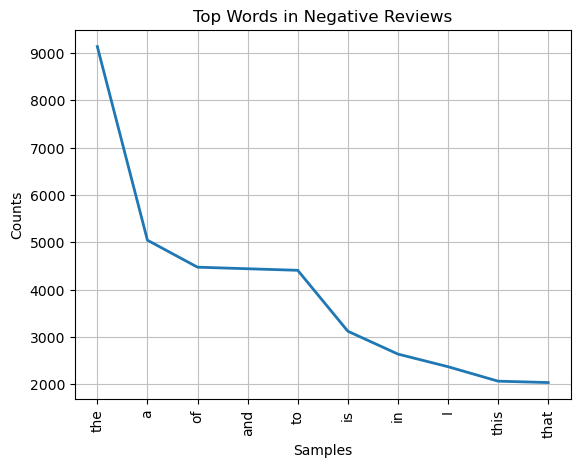

<Axes: title={'center': 'Top Words in Negative Reviews'}, xlabel='Samples', ylabel='Counts'>

In [198]:
# Word Frequency Distribution
# Combine all text from negative reviews
negative_text = " ".join(dataset[dataset['sentiment'] == 'negative']['review'])

negative_tokens = negative_text.split()
negative_freq_dist = FreqDist(negative_tokens)

print("\nTop Words in Negative Reviews:")
print(negative_freq_dist.most_common(10))
negative_freq_dist.plot(10, title="Top Words in Negative Reviews")

# Data Preprocessing


In [199]:
#Text Preprocessing
custom_stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
    "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of",
    "at", "by", "for", "with", "about", "against", "between", "into", "through",
    "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then",
    "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor",
    "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can",
    "will", "just", "don", "should", "now"
])
# Initialize  lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphabetic numeric characters
    text = re.sub(r'<.*?>', '', text)          # Remove HTML tags if any
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    # Remove URLs
    text = re.sub(r'\d+', '', text)
    tokens = text.split() 
    
    # Tokenize
    tokens = [word for word in tokens if word not in custom_stopwords]  # Remove stopwords
  
    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
     return ' '.join(tokens)


In [200]:
# Apply preprocessing to review column
dataset['cleaned_review'] = dataset['review'].apply(preprocess_text)
print(dataset[['review', 'cleaned_review']].head())

                                              review  \
0  I really liked this Summerslam due to the look...   
1  Not many television shows appeal to quite as m...   
2  The film quickly gets to a major chase scene w...   
3  Jane Austen would definitely approve of this o...   
4  Expectations were somewhat high for me when I ...   

                                      cleaned_review  
0  really liked summerslam due look arena curtain...  
1  many television show appeal quite many differe...  
2  film quickly get major chase scene ever increa...  
3  jane austen would definitely approve onebr br ...  
4  expectation somewhat high went see movie thoug...  


In [201]:
#Feature Extraction
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000)
X = tfidf_vectorizer.fit_transform(dataset['cleaned_review'])
y = dataset['sentiment'].map({'positive': 1, 'negative': 0})  # Encode sentiments


In [202]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Text Classification And Sentiment Analysis

In [203]:
# Train SVM Model
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train, y_train)


SVC(C=1, kernel='linear', random_state=42)

In [204]:
# Predict and Evaluate
y_pred = svm_model.predict(X_test)

# Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2%}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 82.19%
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       164
           1       0.79      0.87      0.83       156

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.83      0.82      0.82       320

Confusion Matrix:
 [[128  36]
 [ 21 135]]


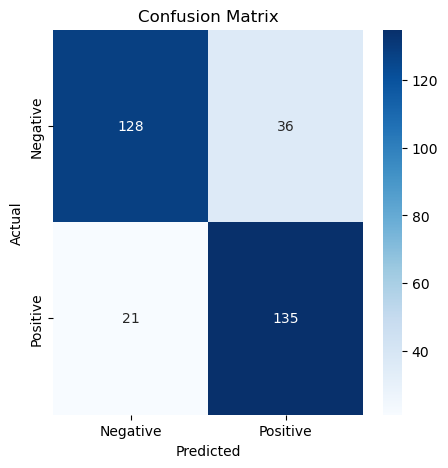

In [205]:
# Confusion Matrix Visualization
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [206]:

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function to check sentiment scores
def check_word_sentiment(word):
    sentiment = sia.polarity_scores(word)
    return sentiment

# Test VADER on individual words
word_list = ["amazing", "terrible", "okay", "mediocre", "excellent", "horrible"]
word_sentiments = {word: check_word_sentiment(word) for word in word_list}

# Print sentiment scores for the words
for word, sentiment in word_sentiments.items():
    print(f"Word: {word} -> Sentiment: {sentiment}")

#  Check sentiment for a specific review
example_review = "This movie was absolutely amazing and had excellent performances."
review_sentiment = sia.polarity_scores(example_review)
print("\nReview Sentiment Scores:", review_sentiment)

Word: amazing -> Sentiment: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5859}
Word: terrible -> Sentiment: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4767}
Word: okay -> Sentiment: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.2263}
Word: mediocre -> Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Word: excellent -> Sentiment: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
Word: horrible -> Sentiment: {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}

Review Sentiment Scores: {'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'compound': 0.8313}


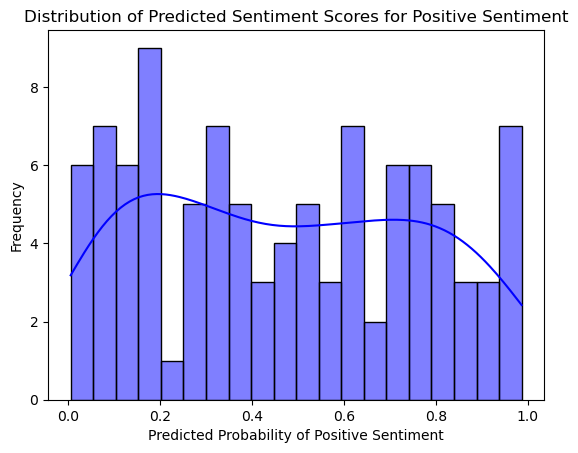

In [193]:
# Simulated predicted probabilities for illustration
np.random.seed(42)
predicted_probabilities = np.random.rand(100)  # Random probabilities between 0 and 1

#  Visualize Predicted Probabilities for positive sentiment
sns.histplot(predicted_probabilities, kde=True, bins=20, color='blue')
plt.title("Distribution of Predicted Sentiment Scores for Positive Sentiment")
plt.xlabel("Predicted Probability of Positive Sentiment")
plt.ylabel("Frequency")
plt.show()

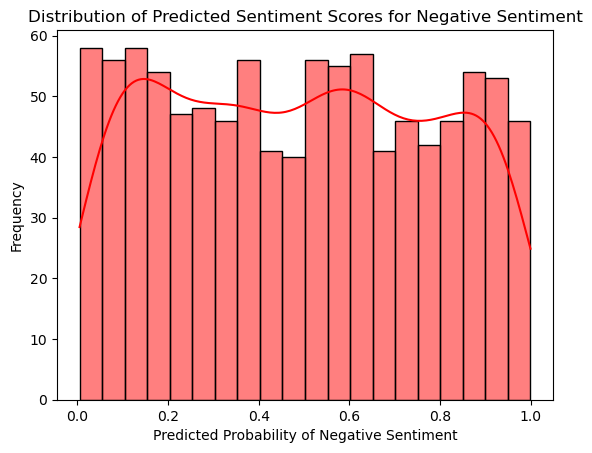

In [196]:
#  Visualize Predicted Probabilities for negative sentiment
np.random.seed(42)
negative_probabilities = np.random.rand(1000)  
sns.histplot(negative_probabilities, kde=True, bins=20, color='red')
plt.title("Distribution of Predicted Sentiment Scores for Negative Sentiment")
plt.xlabel("Predicted Probability of Negative Sentiment")
plt.ylabel("Frequency")
plt.show()

In [216]:


# Ensure the 'compound_score' column exists
random.seed(42)
if 'compound_score' not in dataset.columns:
    dataset['compound_score'] = [random.uniform(-1, 1) for _ in range(len(dataset))]

# Create the 'sentiment_class' column
dataset['sentiment_class'] = dataset['compound_score'].apply(lambda x: 'negative' if x <= 0 else 'positive')

# Calculate the percentage of positive reviews
positive_reviews_count = len(dataset[dataset['sentiment_class'] == 'positive'])
total_reviews_count = len(dataset)
positive_reviews_percentage = (positive_reviews_count / total_reviews_count) * 100

# Calculate the percentage of negative reviews
negative_reviews_count = len(dataset[dataset['sentiment_class'] == 'negative'])
negative_reviews_percentage = (negative_reviews_count / total_reviews_count) * 100

# Display the percentages
print(f"Percentage of Positive Reviews: {positive_reviews_percentage:.2f}%")
print(f"Percentage of Negative Reviews: {negative_reviews_percentage:.2f}%")

Percentage of Positive Reviews: 49.75%
Percentage of Negative Reviews: 50.25%
